In [1]:
import sys
import time
import warnings

#!{sys.executable} -m pip install unidecode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pre-processing
import re
import unidecode
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/askani.mohankrishna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/askani.mohankrishna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import pandas as pd
train_data = pd.read_csv('X_train_ig.csv')
train_data.head()

,Unnamed: 0,body
0,102,#LatePost #Mudik #Flood
1,117,Pray for the KM ship to work beautifully\n#pra...
2,385,🌊Flash Flood!\n\nLas inundaciones relámpago o ...
3,395,I think we've had enough rain. 😕\n\nI'm going ...
4,396,Fence lines are coming down. I’ve really never...


In [3]:
train_labels = pd.read_csv('y_train_ig.csv')
train_labels.head()

,Unnamed: 0,category
0,102,flood
1,117,flood
2,385,flood
3,395,flood
4,396,flood


In [4]:
train_data = train_data[['body']]
train_data.head()

,body
0,#LatePost #Mudik #Flood
1,Pray for the KM ship to work beautifully\n#pra...
2,🌊Flash Flood!\n\nLas inundaciones relámpago o ...
3,I think we've had enough rain. 😕\n\nI'm going ...
4,Fence lines are coming down. I’ve really never...


In [5]:
train_labels['category'].value_counts()

none     287
flood    277
Name: category, dtype: int64

In [6]:
import re
from tqdm import tqdm
def preprocess(article):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the article
    text = article.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
preprocessed = [preprocess(article) for article in tqdm(train_data['body'])]

100%|██████████| 564/564 [00:00<00:00, 19240.55it/s]


In [7]:
preprocessed[3]

"think we've had enough rain i'm going to try to stay patient with this and keep it in mind the next time we're going through drought it's too easy to just get lost in the overwhelming issues this could lead to we'll dry out sooner or later all humans and animals on the homestead are safe and in various states of dry texas homesteading northtexas homesteadingmama womenwhofarm growbuildraise iamcountryside backyardchickens flashflood rain"

In [8]:
from collections import Counter
counts = dict(Counter(word for sentence in preprocessed for word in sentence.split()))
{k: counts[k] for k in list(counts)[:10]}

{'latepost': 1,
 'mudik': 1,
 'flood': 275,
 'pray': 3,
 'for': 219,
 'the': 1077,
 'km': 2,
 'ship': 2,
 'to': 557,
 'work': 22}

In [9]:
test_data = pd.read_csv('X_test_ig.csv')

data_test = test_data['body']
data_test = [preprocess(article) for article in tqdm(data_test)]

test_labels = pd.read_csv('y_test_ig.csv')


100%|██████████| 188/188 [00:00<00:00, 23909.31it/s]


In [10]:
embed_size = 300 # how big is each word vector
max_features = 8900 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 500 # max number of words in a content to use

In [11]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(preprocessed)
train_X = tokenizer.texts_to_sequences(preprocessed)
test_X = tokenizer.texts_to_sequences(data_test)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

le = LabelEncoder()
train_y = le.fit_transform(train_labels['category'].values)
test_y = le.transform(test_labels['category'].values)
len(le.classes_)

2

In [12]:
len(tokenizer.word_index)

8899

In [13]:
import pickle
with open("tokenizer_flood_v1.pkl", 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)
with open("label_encoder_flood_v1.pkl", 'wb') as file:
    pickle.dump(le, file, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
EMBEDDING_FILE = 'glove.840B.300d.txt'
debug = 0
def load_glove(word_index):
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    del embeddings_index['PN']
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

if debug:
    embedding_matrix = np.random.randn(max_features,embed_size)
else:
    embedding_matrix = load_glove(tokenizer.word_index)
np.shape(embedding_matrix)

/Users/askani.mohankrishna/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(8900, 300)

In [15]:
import numpy as np
np.save('embedding_matrix__flood_v1.npy' , embedding_matrix)

In [16]:
train_X1 = train_X[:2]

#Paste num in self.extra_features below 
train_X1.shape[1] - maxlen

0

In [17]:
class BiLSTM(nn.Module): 
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size_1 = 64
        self.hidden_size_2 = 64
        self.extra_features = 0
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size_1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size_1*4 + self.extra_features, self.hidden_size_2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(self.hidden_size_2, n_classes)

    def forward(self, x):
        input = x[:,:maxlen]
        of = x[:,maxlen:]
        
        h_embedding = self.embedding(input)
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool, of), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [53]:
n_epochs = 5
batch_size = 20


model = BiLSTM()

loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long)#.cuda()
y_train = torch.tensor(train_y, dtype=torch.long)#.cuda()

x_cv = torch.tensor(test_X, dtype=torch.long)#.cuda()
y_cv = torch.tensor(test_y, dtype=torch.long)#.cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))


<ipython-input-53-568106fbcc4e>:53: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * batch_size:(i+1) * batch_size] = F.softmax(y_pred).cpu().numpy()


Epoch 1/5 	 loss=13.4136 	 val_loss=12.6512  	 val_acc=0.5904  	 time=11.46s
Epoch 2/5 	 loss=12.6272 	 val_loss=11.6781  	 val_acc=0.7021  	 time=11.10s
Epoch 3/5 	 loss=10.0933 	 val_loss=10.1283  	 val_acc=0.7606  	 time=11.05s
Epoch 4/5 	 loss=6.6515 	 val_loss=9.7213  	 val_acc=0.7394  	 time=11.05s
Epoch 5/5 	 loss=3.7561 	 val_loss=10.5157  	 val_acc=0.7713  	 time=10.99s


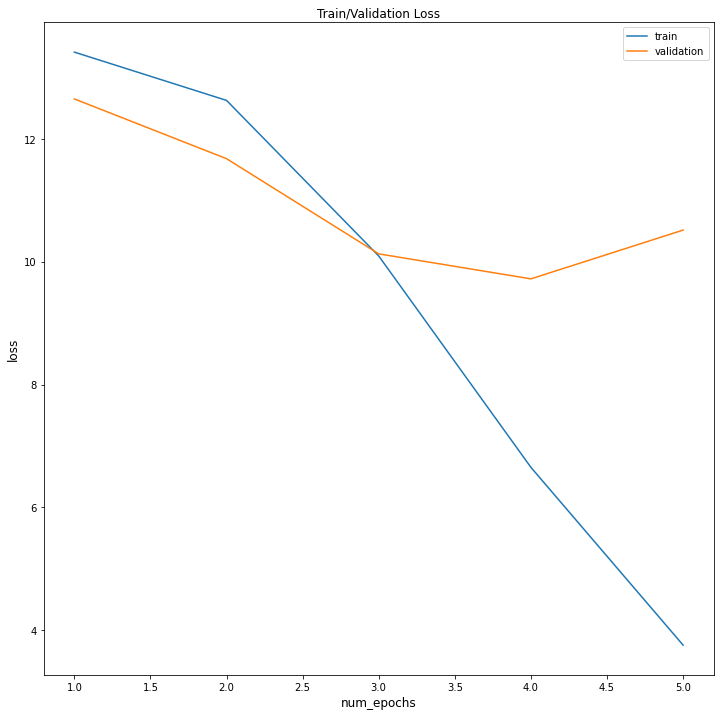

In [54]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(n_epochs)

In [55]:
pred = le.inverse_transform(val_preds.argmax(axis=1))
test = le.inverse_transform(test_y)
from sklearn.metrics import classification_report
print(classification_report(test,pred,labels=train_labels['category'].unique()))

              precision    recall  f1-score   support

       flood       0.80      0.76      0.78        99
        none       0.74      0.79      0.77        89

    accuracy                           0.77       188
   macro avg       0.77      0.77      0.77       188
weighted avg       0.77      0.77      0.77       188



In [56]:
filename = 'model_instagram_flood_v1.pt'
torch.save(model.state_dict(), filename)